In [1]:
%load_ext autoreload
%autoreload 2

import sys

sys.path.append("../..")
import logging

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from xlstm_scaling_laws.analysis.tokenparam.plot_pareto_frontier import convex_hull
from xlstm_scaling_laws.common.load_data import (
    get_default_run_data_calc_config,
    load_run_data,
)
from xlstm_scaling_laws.fitting.fit_power_law import fit_power_law, power_law
from xlstm_scaling_laws.load_data.datafiles import RunDataSet, get_run_data_file
from xlstm_scaling_laws.run_data import RunData

While loading IsoFLOP Runs: Overriding attention flop calc mode to distill_scaling.
KeyError: 'dataset/'. While creating RunData from WandBRunData(name=dclm_mLSTMv1_80M_ctx2048_lr0.003_steps16400_nb10_ed512_nh4_pf2.667_gbs512, id=0m5bmumq, path=['xlstm', 'xlstm_jax', '0m5bmumq'], created_at=2025-04-13T06:17:04Z)
KeyError: 'dataset/'. While creating RunData from WandBRunData(name=dclm_mLSTMv1_200M_ctx2048_lr0.003_steps3000_nb27_ed896_nh7_pf2.667_gbs512, id=ch1anxyv, path=['xlstm', 'xlstm_jax', 'ch1anxyv'], created_at=2025-04-13T17:35:13Z)
KeyError: 'dataset/'. While creating RunData from WandBRunData(name=dclm_mLSTMv1_80M_ctx2048_lr0.003_steps27200_nb10_ed512_nh4_pf2.667_gbs512, id=52pij92y, path=['xlstm', 'xlstm_jax', '52pij92y'], created_at=2025-04-13T08:12:40Z)
KeyError: 'dataset/'. While creating RunData from WandBRunData(name=dclm_mLSTMv1_500M_ctx2048_lr0.002_steps9600_nb27_ed1152_nh9_pf2.667_gbs512, id=oyn1hwkt, path=['xlstm', 'xlstm_jax', 'oyn1hwkt'], created_at=2025-04-14T17:41:

In [2]:
df = load_run_data(
    wandb_run_data_dict_file=get_run_data_file(data_set=RunDataSet.TOKENPARAM_MLSTM),
    run_data_class=RunData,
    config_calc_run_data=get_default_run_data_calc_config(
        attention_flop_calc_mode="distill_scaling",
        mlstm_fw_flop_calc_mode="first",
    ),
    group_runs_by="name",
)

# extend dict with additional rows
df2 = load_run_data(
    wandb_run_data_dict_file=get_run_data_file(data_set=RunDataSet.TOKENPARAM_LLAMA),
    run_data_class=RunData,
    config_calc_run_data=get_default_run_data_calc_config(
        attention_flop_calc_mode="distill_scaling",
        mlstm_fw_flop_calc_mode="first",
    ),
    group_runs_by="name",
)

df = df | df2

run_tags = [
    "scl_mlstm_160Mv2",
    "scl_mlstm_400M",
    "scl_mlstm_830M",
    "scl_mlstm_1.4B",
    "scl_mlstm_2.7B",
    "scl_mlstm_7B",
    "dclm_mLSTMv1_7B_longrun_pretraining_final",
    "scl_llama_160M",
    "scl_llama_400M",
    "scl_llama_830Mv2",
    "scl_llama_1.4Bv2",
    "scl_llama_2.7B",
    "scl_llama_7B",
]
df = {k: v for k, v in df.items() if k in run_tags}

Could not extract chunk size from backend kwargs '{'backend_name': 'chunkwise--triton_xl_chunk'}' from run WandBRunData(name=dclm_mLSTMv1_160M_ctx8192_lr0.003_steps18000_gbs128, id=djkqz1dc, path=['xlstm', 'xlstm_jax', 'djkqz1dc'], created_at=2024-12-19T15:53:36Z).Using default chunk size of 64.
Could not extract chunk size from backend kwargs '{'backend_name': 'max_triton_noslice'}' from run WandBRunData(name=dclm_mLSTMv1_7B_ctx8192_gbs512, id=hphy3hsq, path=['xlstm', 'xlstm_jax', 'hphy3hsq'], created_at=2024-11-06T22:21:03Z).Using default chunk size of 64.


In [3]:
print(len(df))
print(df.keys())

13
dict_keys(['scl_mlstm_160Mv2', 'scl_mlstm_400M', 'scl_mlstm_830M', 'scl_mlstm_1.4B', 'scl_mlstm_2.7B', 'scl_mlstm_7B', 'dclm_mLSTMv1_7B_longrun_pretraining_final', 'scl_llama_160M', 'scl_llama_400M', 'scl_llama_830Mv2', 'scl_llama_1.4Bv2', 'scl_llama_2.7B', 'scl_llama_7B'])


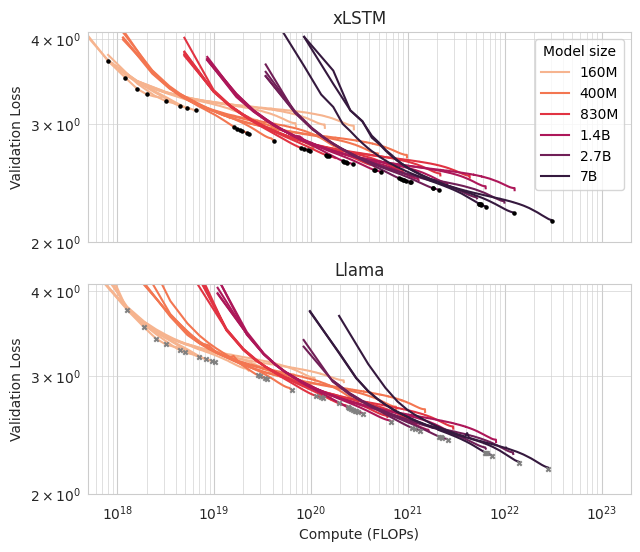

In [4]:
all_run_tags = [
    [
        "scl_mlstm_160Mv2",
        "scl_mlstm_400M",
        "scl_mlstm_830M",
        "scl_mlstm_1.4B",
        "scl_mlstm_2.7B",
        "scl_mlstm_7B",
        # "dclm_mLSTMv1_7B_longrun_pretraining_final"
    ],
    [
        "scl_llama_160M",
        "scl_llama_400M",
        "scl_llama_830Mv2",
        "scl_llama_1.4Bv2",
        "scl_llama_2.7B",
        "scl_llama_7B",
    ],
]

cmap = sns.color_palette("rocket_r", n_colors=6)
colors = {
    "160M": cmap[0],
    "400M": cmap[1],
    "830M": cmap[2],
    "1.4B": cmap[3],
    "2.7B": cmap[4],
    "7B": cmap[5],
}

# window = 1

with sns.axes_style("whitegrid"):
    fig, axs = plt.subplots(2, 1, figsize=(7, 6), sharex=True)

all_losses, all_flops, all_tokens, all_params = [[], []], [[], []], [[], []], [[], []]

for m, (run_tags, ax) in enumerate(zip(all_run_tags, axs)):
    for run_tag in run_tags:
        for r, rundata in enumerate(df[run_tag]):
            # print(rundata._raw_data[0].logs.keys())
            # print(rundata._raw_data[0].logs["val/.dclm_loss"]["val/.dclm_loss"])
            # print(rundata._raw_data[0].logs["val/.dclm_loss"]["_step"])
            # print(f"{rundata.num_tokens_training / 1e9:.2f}")

            loss, flops, tokens = [], [], []

            for i in range(len(rundata._raw_data)):
                flops.extend(
                    (
                        rundata._raw_data[i].logs["val/.dclm_loss"]["_step"]
                        * rundata.num_flops_training
                        / rundata.num_train_steps
                    ).tolist()
                )
                tokens.extend(
                    (
                        rundata._raw_data[i].logs["val/.dclm_loss"]["_step"]
                        * rundata.num_tokens_training
                        / rundata.num_train_steps
                    ).tolist()
                )
                loss.extend(
                    rundata._raw_data[i]
                    .logs["val/.dclm_loss"]["val/.dclm_loss"]
                    .tolist()
                )

            # if loss[0] < 7:
            #     # skip runs with very low loss, e.g. distillation runs
            #     continue

            # pad = ([loss[0]] * window)
            # loss = pad + loss

            # smoothed_loss = [np.mean(loss[i-window:i]) for i in range(window, len(loss))]

            index = -1
            for c in colors.keys():
                if c in run_tag:
                    index = list(colors.keys()).index(c)
                    break
            if index == -1:
                color = "black"
            else:
                color = colors[list(colors.keys())[index]]

            ax.plot(flops, loss, color=color)

            all_losses[m].extend(loss)
            all_flops[m].extend(flops)
            all_tokens[m].extend(tokens)
            all_params[m].extend([rundata.num_params] * len(loss))

        ax.set_yscale("log")
        ax.set_xscale("log")
        ax.set_ylim(2, 4.1)
        ax.grid(which="minor", linestyle="-", linewidth=0.5, color="lightgrey")
        ax.set_xlim(5e17, 2e23)
        ax.set_ylabel("Validation Loss")
axs[1].set_xlabel("Compute (FLOPs)")
for k, v in colors.items():
    axs[0].plot([], [], color=v, label=k)
axs[0].legend(title="Model size", loc="upper right", fontsize=10)
axs[0].set_title("xLSTM")
axs[1].set_title("Llama")

# calculate envelope
ch_losses, ch_flops, ch_params, ch_tokens = [[], []], [[], []], [[], []], [[], []]
bins_per_flop_magnitude = 15
min_flops, max_flops = 2e18, 1e23
for m in range(len(all_losses)):
    sorted_losses = np.array(all_losses[m])
    sorted_flops = np.array(all_flops[m])
    sorted_indices = np.argsort(sorted_flops)
    sorted_flops = sorted_flops[sorted_indices]
    sorted_losses = sorted_losses[sorted_indices]
    sorted_tokens = np.array(all_tokens[m])[sorted_indices]
    sorted_params = np.array(all_params[m])[sorted_indices]

    # append minimum of both axes to close the polygon and remove at the end
    points = np.vstack([sorted_flops, sorted_losses]).T
    points = np.vstack(
        [
            points,
            np.array([points[:, 0].max(), points[:, 1].max()]),
        ]
    )
    _, indices = convex_hull(points)
    indices = np.sort(indices)[:-1]
    # discard if higher than 4 loss
    indices = indices[sorted_losses[indices] < 4]

    ch_flops[m].extend(sorted_flops[indices])
    ch_losses[m].extend(sorted_losses[indices])
    ch_tokens[m].extend(sorted_tokens[indices])
    ch_params[m].extend(sorted_params[indices])

    axs[m].scatter(
        ch_flops[m],
        ch_losses[m],
        color="black" if m == 0 else "gray",
        marker="o" if m == 0 else "x",
        s=5 if m == 0 else 10,
        zorder=99,
    )

plt.show()

/home/max/myrepos/nxai_public/mlstm_scaling_laws/notebooks_plots/scaling_law_training_plots__paper/../../xlstm_scaling_laws/fitting/fit_power_law.py:24: RuntimeWarning: invalid value encountered in log
  return np.log(a) + alpha * np.log(x)


[]

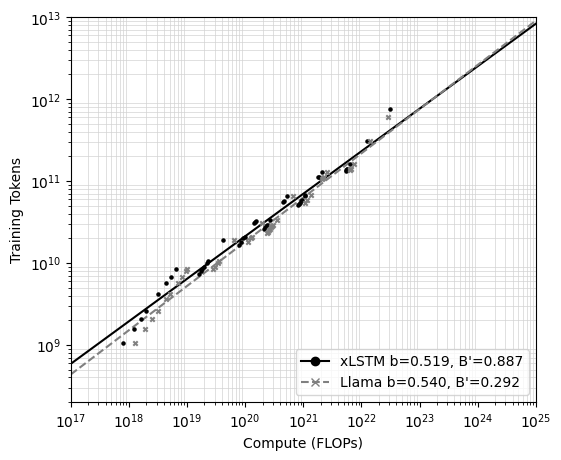

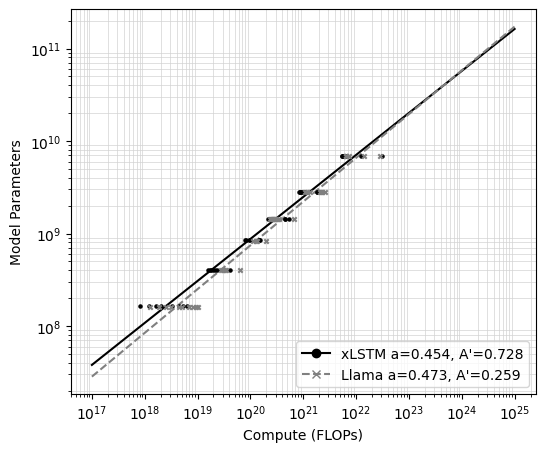

In [5]:
plt.figure(figsize=(6, 5))

envelope_colors = ["black", "gray"]
envelope_markers = ["o", "x"]
envelope_markersizes = [5, 10]
envelope_linestyles = ["-", "--"]
n_points = 100

for m in range(2):
    plt.scatter(
        ch_flops[m],
        ch_tokens[m],
        color=envelope_colors[m],
        s=envelope_markersizes[m],
        zorder=99,
        marker=envelope_markers[m],
    )

# fit a line to the envelope
for m, k in enumerate(
    zip(envelope_markers, envelope_colors, envelope_linestyles, ["xLSTM", "Llama"])
):
    if len(ch_flops[m]) == 0:
        continue

    df = pd.DataFrame(
        {
            "flop_mean": ch_flops[m],
            "num_tokens_training": ch_tokens[m],
        }
    )

    popt, pcov, _ = fit_power_law(
        df,
        fit_in_log_space=True,
    )
    B, b = popt
    B_std, b_std = np.sqrt(np.diag(pcov))
    x_vals = np.logspace(np.log10(1e17), np.log10(1e25), n_points)
    y_vals = power_law(x_vals, B, b)
    plt.plot(
        x_vals,
        y_vals,
        color=envelope_colors[m],
        linestyle=envelope_linestyles[m],
        linewidth=1.5,
    )
    plt.plot(
        [],
        [],
        marker=k[0],
        color=k[1],
        linestyle=k[2],
        label=f"{k[-1]} b={b:.3f}, B'={B:.3f}",
    )
plt.legend(loc="lower right", fontsize=10)
plt.yscale("log")
plt.xscale("log")
plt.ylim(2e8, 1e13)
plt.xlim(1e17, 1e25)
plt.ylabel("Training Tokens")
plt.xlabel("Compute (FLOPs)")
plt.grid(which="minor", linestyle="-", linewidth=0.5, color="lightgrey")
plt.plot()

plt.figure(figsize=(6, 5))


# subselect the lowest loss in envelope for each model size
for m in range(len(all_losses)):
    plt.scatter(
        ch_flops[m],
        ch_params[m],
        color=envelope_colors[m],
        s=envelope_markersizes[m],
        zorder=99,
        marker=envelope_markers[m],
    )

# fit a line to the envelope
for m, k in enumerate(
    zip(envelope_markers, envelope_colors, envelope_linestyles, ["xLSTM", "Llama"])
):
    if len(ch_flops[m]) == 0:
        continue

    df = pd.DataFrame(
        {
            "flop_mean": ch_flops[m],
            "num_params": ch_params[m],
        }
    )

    popt, pcov, _ = fit_power_law(df, y_col="num_params", fit_in_log_space=True)
    A, a = popt
    A_std, a_std = np.sqrt(np.diag(pcov))
    x_vals = np.logspace(np.log10(1e17), np.log10(1e25), n_points)
    y_vals = power_law(x_vals, A, a)
    plt.plot(
        x_vals,
        y_vals,
        color=envelope_colors[m],
        linestyle=envelope_linestyles[m],
        linewidth=1.5,
    )
    plt.plot(
        [],
        [],
        marker=k[0],
        color=k[1],
        linestyle=k[2],
        label=f"{k[-1]} a={a:.3f}, A'={A:.3f}",
    )
plt.legend(loc="lower right", fontsize=10)
plt.yscale("log")
plt.xscale("log")
plt.ylabel("Model Parameters")
plt.xlabel("Compute (FLOPs)")
plt.grid(which="minor", linestyle="-", linewidth=0.5, color="lightgrey")
plt.plot()